<h1> BrainStation Capstone Project</h1>

<b>Is the song "hot enough" for Billboard Hot100 🔥</b>
<br> Predicting the probability of a song reaching the Billboard Hot100 chart.</br>

Author: Hailey Lee
<br>Contact: ejlee.hailey@gmail.com
<br>Date: June 30, 2022

---

# Introduction & Data Acquisition

#### Table of Contents:
* [Introduction](#introduction)
    * [Project Details](#details)
    * [Data Sources](#datasources)
    * [Challenges](#challenges)
* [Data Acquisition](#dataacquisition)
    * [Webscraping for Billboard Stats](#webscrape)
    * [Extracting Data from Spotify](#spotify)
    * [Extracting Data from Genius](#genius)
* [Data Cleaning & Merging](#datasets)
    * [Kaggle dataset](#kaggle)
    * [Genius dataset](#genius)

---

### Introduction<a class="anchor" id="introduction"></a>

Before we begin... what is a "song"?

According to [Merriam Webster](https://www.merriam-webster.com/dictionary/song), a song is simply a a short musical composition of words and music. That leads to our problem statement:
<p><center><i>How can we analyze a song's words(lyrics) and music (audio metrics) such that we can predict the probability of its success?</i></center> 
<p>But we also need to define the "success" of a song, because success is such a subjective term. In this scenario, we will be measuring success by the Billboard charts, specifically [Hot100](https://www.billboard.com/charts/hot-100/). Since its inception in 1958, the Billboard Hot100 has become the music industry's standard record chart in the United States for top 100 songs. Their algorithm is based on:

1. Retail and Digital sales
2. Radio airplay and audience impressions
3. Streaming activity from online sources (such as Spotify, Apple Music, YouTube, Pandora, etc.)
    
What inspired me to pursue this topic initially was the rise of K-pop songs reaching the U.S. Billboard Hot100. Unfortunately due to lack of data, I broadened the scope to all U.S. songs. But after further research, I discovered a trend that could impact the entire industry and possibly the entire world:
<p><center><i>Music is changing.</i></center>
<p>The accessibility and globalization of streaming platforms have conjured up a fusion of genres which we did not even know existed and a discovery of new and emerging artists we have never heard of before. Major label artists have been <a href="https://www.musicbusinessworldwide.com/slowly-but-surely-the-major-labels-dominance-of-spotify-is-declining/" target=_blank>losing share since 2017</a>, and TikTok artists have been making their <a href="https://www.youtube.com/watch?v=S1m-KgEpoow" target=_blank>big break</a> through a single viral song.

### Project Details<a class="anchor" id="details"></a>
This purpose of this project is to build a model that can identify if a song is eligible to be on Billboard Hot100 based on its audio metrics (measured by Spotify) and lyrics. A successful model can help both major label companies and artists waiting for their big break to recognize the level of commercialization of a song.

This project will cover the Billboard period between **January 1, 2008 through May 7, 2022** (which is the week I webscraped the data). The intention was pull the most recent songs so we can verify the trends according to the research mentioned above. Lastly, the start date of 2008 was not arbitrary. Due to my initial intentions of the project (identifying k-pop songs that could Billboard Hot100), I wanted the project to start from when the first k-pop song hit the charts back in 2009 with a song called ["Nobody" by Wonder Girls](https://www.billboard.com/artist/wonder-girls/). 

### Data Sources<a class="anchor" id="datasources"></a>

To make this project possible, I looked at three main sources for data:

1. Billboard.com website for Billboard stats
2. Spoyify API for audio metrics
3. Genius API for song lyrics

And because this is a binary classification problem, I also looked at data.world and Kaggle to represent songs in Class 0 (i.e., songs that were not on the Billboard Hot100). These are the two datasets I used were from [data.world](https://data.world/babarory/spotify-dataset-1921-2020) and [Kaggle](https://www.kaggle.com/datasets/imuhammad/audio-features-and-lyrics-of-spotify-songs).

### Challenges<a class="anchor" id="challenges"></a>

The biggest challenge for this project was merging data. Because a single dataset was pulling data from multiple sources, it needed a primary key column that was common in each source and conatined unique identifiers for each song. Initially, I tried to accomplish this by using song titles or a combination of song and title, but I ran into problems like this:

|Common Identifier| Source 1 | Source 2 | Comments  |
|:---------------:|:---------|:---------|:----------|
| song title | Forever | Forever | ❌ No match. The first song is by Chris Brown and the second song is by Lil Wayne
| song title | Scream and Shout | Scream & Shout | ❌ No match. They are the same songs by will.i.am but the spelling is different.
| song title + artist | Bam Bam Camila Cabello | Bam Bam Camila Cabello feat. Ed Sheeran | ❌ No match. Some sources did not include featured artist information.
<br>

After several creative efforts, I resorted to a combination of using Spotify's track URI (uniform resource identifier) and a special Python package called [FuzzyWuzzy](https://pypi.org/project/fuzzywuzzy/) which uses Levenshtein Distance to calculate the similarity between two strings.

---
### Data Acquisition<a class="anchor" id="dataacquisition"></a>

> **Disclaimer:** The following codes below were not used in conjunction with one another as this process required many iterations, verifications, and corrections. However, the codes do work successfully if running it as an independent task.

First, let's make sure the proper packages are installed. Please refer to the requirements.txt file for instructions on setting up the environment.

```python
pip install beautifulsoup4
pip install spotipy
pip install lyricsgenius
```

In [1]:
# webscraping
from bs4 import BeautifulSoup

# spotify
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# genius
from lyricsgenius import Genius

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import requests
import itertools

### Webscraping for Billboard Stats<a class="anchor" id="webscrape"></a>

Billboard.com has made it easy in the sense that all pages are structured in a clean and consistent way. The URL format that leads to each of their weekly Hot100 chart is `https://www.billboard.com/charts/hot-100/{yyyy}-{mm}-{dd}/`. When running the `webscrape_billboard` function, the user just needs to enter the latest date in YYYY-MM-DD format and the number of weeks they want to go back.

The global dictionary `updated_dict` must also be run to store and extract the results.

In [ ]:
# global dictionary to store data
updated_dict = {
    'year':[],
    'week':[],
    'rank':[],
    'song':[],
    'artist':[],
    'peak_position':[],
    'weeks_on_chart':[]
}

# function starts here
def webscrape_billboard(date, weeks):
    '''
    Webscrapes from www.billboard.com to pull songs, artists, ranks, peak positions, and weeks on chart from Hot 100.
    Billboard Hot 100 is updated every week. Each webpage represents a week of top 100 songs.
    
    Parameters
    ----------
    date:  string, the start week for scrape in format 'YYYY-MM-DD'
            * note: must be a SATURDAY
    weeks: integer, number weeks to scrape (go backwards from 'start' date)
            * note: each week is a new webpage
    
    Note: Must ensure dictionary is initialized in variable 'updated_dict'
    
    Returns
    -------
    ret:   updated dictionary (global variable 'updated_dict')

    ''' 
    # start a for loop
    for week in range(0, weeks):
        
        # pulls the webpage of respective week and parses html
        url = f'https://www.billboard.com/charts/hot-100/{date}/'
        
        # url = f'https://www.billboard.com/charts/billboard-korea-100/{date}/'
        page = requests.get(url)
        page_soup = BeautifulSoup(page.content, 'html.parser')
        
        # container for top 100 songs and artists
        container = page_soup.find('div', {'class': 'chart-results-list'})
        
        # empty lists to store data
        year_list = []
        date_list = []
        song_list = []
        rank_list = []
        artist_list = []
        peak_pos_list = []
        wks_chart_list = []
        
        # pulls container for song information only and filters unwanted text
        song_container = container.find_all('h3', {'class':'c-title'})
        unwanted = ['Gains in Weekly Performance', 'Additional Awards', 'Songwriter(s):', 'Producer(s):',
                    'Imprint/Promotion Label:']
        
        for song in song_container:
            song_list.append(song.text.strip())
            for word in song_list:
                if word in unwanted:
                    song_list.remove(word)
        
        # pulls container for rank, artist, peak position, weeks on chart
        music_container = container.find_all('span', {'class':'c-label'})
        
        # filter music_container for unwanted text to keep consistent step size when indexing
        unfiltered_list = []
        for x in music_container:
            unfiltered_list.append(x.text.strip())
        filtered_list = ([x for x in unfiltered_list if x not in ['NEW', 'RE-\nENTRY']])

        # counters to iterate through container and pull respective text by index
        rank_counter = np.arange(0,len(filtered_list),8)
        artist_counter = np.arange(1,len(filtered_list),8)
        peak_pos_counter = np.arange(3,len(filtered_list),8)
        wks_chart_counter = np.arange(4,len(filtered_list),8)
        
        # iterate and append remaining lists
        for i, j, k, l in zip(rank_counter, artist_counter, peak_pos_counter, wks_chart_counter):
            rank_list.append(filtered_list[i])
            artist_list.append(filtered_list[j])
            peak_pos_list.append(filtered_list[k])
            wks_chart_list.append(filtered_list[l])
        
        # additional lists to match array shape
        year_list.extend(repeat(date[0:4],100))
        date_list.extend(repeat(date,100))
        
        # append to existing dictionary
        updated_dict['year'].extend(year_list)
        updated_dict['week'].extend(date_list)
        updated_dict['rank'].extend(rank_list)
        updated_dict['song'].extend(song_list)
        updated_dict['artist'].extend(artist_list)
        updated_dict['peak_position'].extend(peak_pos_list)
        updated_dict['weeks_on_chart'].extend(wks_chart_list)
        
        # print results to know what's happening
        print('\r', f'Webscrape Success. Week {week + 1} ({date})',end='')
        print('\r', f'Year List Count: {len(year_list)}', end='')
        print('\r', f'Date List Count: {len(date_list)}', end='')
        print('\r', f'Rank List Count: {len(rank_list)}', end='')
        print('\r', f'Song List Count: {len(song_list)}', end='')
        print('\r', f'Artist List Count: {len(artist_list)}', end='')
        print('\r', f'Peak Pos List Count: {len(peak_pos_list)}', end='')
        print('\r', f'Weeks on Chart Count: {len(wks_chart_list)}', end='')
        
        # update the scrape date to the week prior
        date_format = datetime.datetime.strptime(date, '%Y-%m-%d')
        days = datetime.timedelta(7)
        date_new = date_format - days
        date = date_new.strftime('%Y-%m-%d') 

Once the process is complete, we can store the dictionary inside a dataframe and save as a .csv file. 

Example below:

```python
billboard_df = pd.DataFrame(updated_dict)
billboard_df.to_csv('billboard_dataset.csv')
```

After scraping the data, it will look something like below. Note: I separated the featured artists by using the `.split()` method. The code may need to be run a couple times depending on the format. E.g., "feat.", "featuring", "with", "&"
```python
billboard_df[['artist','featured_artist']] = billboard_df.pop('artist').str.split(' feat. ', n=1, expand=True)
```

In [40]:
billboard_df = pd.read_csv('dataset_webscrape.csv')
billboard_df.head()

,year,week,rank,song,artist,featured_artist,peak_position,weeks_on_chart
0,2014,8/9/2014,91,Word Crimes,"""Weird Al"" Yankovic",-,39,2
1,2014,8/2/2014,39,Word Crimes,"""Weird Al"" Yankovic",-,39,1
2,2022,2/19/2022,87,Doja,$NOT & A$AP Rocky,-,87,1
3,2019,5/25/2019,98,Rule The World,2 Chainz,Ariana Grande,94,2
4,2019,3/16/2019,94,Rule The World,2 Chainz,Ariana Grande,94,1


Just from the first five rows above, we can see that the same song and artist appear several times. This is because we scraped the data on a weekly basis, and until the song drops off the chart, it will appear in each weekly scrape. We can see that by the `weeks_on_chart` column that indicates how long a song has been on the charts.

To address this issue I made the following transformations through SQL:
- Find the earliest `week` which will tell us the week that the song first reached the Billboard
- Remove the `rank` column as the `peak_position` column already tells us the highest rank that the song achieved
- Find the highest `weeks_on_chart` which will tell us a total of how long the song stayed on the Billboard

SQL code below:

```sql
SELECT MIN(year) AS year, MIN(week) AS week, song, artist, featured_artist, MIN(peak_position) AS peak_position, MAX(weeks_on_chart) AS weeks_on_chart
	FROM dataset_bbhot100_RAW
	GROUP BY song, artist
```

### Extracting Data from Spotify<a class="anchor" id="spotify"></a>

In order to use Spotify API, user must have an account with Spotify (does not have to be premium) and then also create an account on Spotify's [developer dashboard](https://developer.spotify.com/). Aftering logging in, click "create an app" to access user credentials. We won't be using the web API, although it can be helpful for one-off lookup requests or when you've reached your [rate limit](https://developer.spotify.com/documentation/web-api/guides/rate-limits/). 

In [ ]:
# initiate connection
cid = 'enter your client id here'
secret = 'enter your client secret key here'
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [8]:
# create empty dictionary to store data

spotify_dict = {
    'artist_name':[],
    'artist_uri':[],
    'artist_pop':[],
    'artist_followers':[],
    'artist_genre':[],
    'track_name':[],
    'track_uri':[],
    'track_pop':[],
    'album_name':[],
    'release_date':[],
    'track_duration':[],
    'danceability': [],
    'energy':[],
    'key':[],
    'loudness':[],
    'mode': [],
    'speechiness': [],
    'acousticness': [],
    'instrumentalness': [],
    'liveness': [],
    'valence': [],
    'tempo': [],
    'time_signature': []
}

Spotipy (Python library for Spotify API) has made it so that user has different ways to extracting Spotify data. I started my process in matching Spotify data with the Billboard data by looking up curated ***playlists*** for Billboard songs (just search "Billboard" in the Spotify app).

The image below shows us how to get the URL for the playlist (and it works the same for albums and songs). This link contains the URI which we need in order to look up anything using Spotipy.

Example: `https://open.spotify.com/playlist/`**65ukORSSmpI51gMQUl3T81**`?si=201df8860be44170`

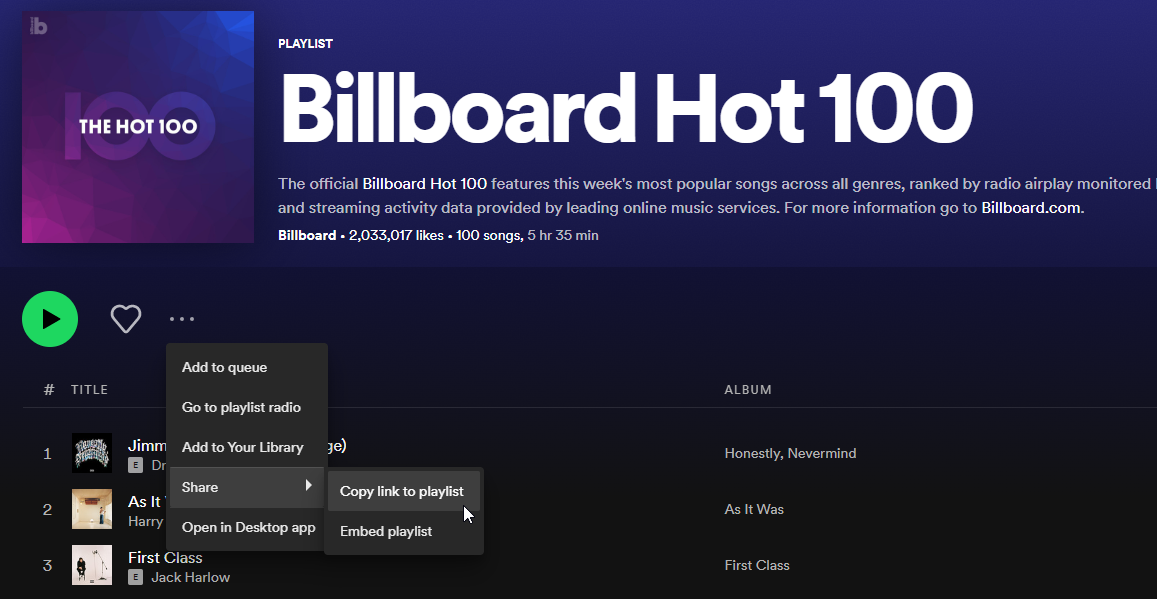

#### Spotipy: Search by `Playlist`

In [ ]:
# pull the playlist uri from URL
playlist_url = 'https://open.spotify.com/playlist/65ukORSSmpI51gMQUl3T81?si=201df8860be44170'
playlist_uri = playlist_url.split("/")[-1].split("?")[0]
playlist_items = sp.playlist_tracks(playlist_uri)['items']


for track in playlist_items:

    # high level track info
    track_items = track['track']
    track_id = track_items["id"]
    info_track = sp.track(track_id)
    
    # track info
    spotify_dict['track_name'].append(track_items['name'])
    spotify_dict['track_uri'].append(track_id)
    spotify_dict['track_pop'].append(track_items['popularity'])  
    spotify_dict['track_duration'].append(track_items['duration_ms'])
    spotify_dict['album_name'].append(track_items['album']['name'])    
    spotify_dict['release_date'].append(info_track['album']['release_date'])
    
    # artist info
    artist_id = track_items['artists'][0]['id']
    spotify_dict['artist_uri'].append(artist_id)
    info_artist = sp.artist(artist_id)
    spotify_dict['artist_name'].append(info_artist["name"])
    spotify_dict['artist_followers'].append(info_artist['followers']['total'])
    spotify_dict['artist_genre'].append(info_artist["genres"])
    spotify_dict['artist_pop'].append(info_artist["popularity"])
    
    # track audio features
    audio_feat = sp.audio_features(track_id)[0]
    spotify_dict['danceability'].append(audio_feat['danceability'])
    spotify_dict['energy'].append(audio_feat['energy'])
    spotify_dict['key'].append(audio_feat['key'])
    spotify_dict['loudness'].append(audio_feat['loudness'])
    spotify_dict['mode'].append(audio_feat['mode'])
    spotify_dict['speechiness'].append(audio_feat['speechiness'])
    spotify_dict['acousticness'].append(audio_feat['acousticness'])
    spotify_dict['instrumentalness'].append(audio_feat['instrumentalness'])
    spotify_dict['liveness'].append(audio_feat['liveness'])
    spotify_dict['valence'].append(audio_feat['valence'])
    spotify_dict['tempo'].append(audio_feat['tempo'])
    spotify_dict['time_signature'].append(audio_feat['time_signature'])

Once the code finishes running, the global dictionary `spotify_dict` will contain the extracted information. We can call `pd.DataFrame()` to convert the data into a dataframe.

We can also search by albums with a few tweaks in the code:

#### Spotipy: Search by `Album`

In [3]:
# pull the album uri from URL
album_url = 'https://open.spotify.com/album/6s84u2TUpR3wdUv4NgKA2j?si=CUb0utWfR0Ctw_wyMy9o0Q'
album_uri = album_url.split("/")[-1].split("?")[0]

# call album
album = sp.album(album_uri)
length = album['total_tracks']

for x in range(0, length):
    
    # artist info
    artist_id = album['artists'][0]['id']
    spotify_dict['artist_name'].append(album['artists'][0]['name'])
    spotify_dict['artist_uri'].append(album['artists'][0]['id'])
    spotify_dict['artist_followers'].append(sp.artist(artist_id)['followers']['total'])
    spotify_dict['artist_genre'].append(sp.artist(artist_id)['genres'])
    spotify_dict['artist_pop'].append(sp.artist(artist_id)['popularity'])
    
    # track info
    track_items = album['tracks']['items'][x]
    track_id = track_items['id']
    spotify_dict['track_name'].append(track_items['name'])
    spotify_dict['track_uri'].append(track_items['id'])
    spotify_dict['track_pop'].append(sp.track(track_id)['popularity'])
    spotify_dict['track_duration'].append(track_items['duration_ms'])
    spotify_dict['album_name'].append(album['name'])
    spotify_dict['release_date'].append(album['release_date'])
    
    # track audio features
    audio_feat = sp.audio_features(track_id)[0]
    spotify_dict['danceability'].append(audio_feat['danceability'])
    spotify_dict['energy'].append(audio_feat['energy'])
    spotify_dict['key'].append(audio_feat['key'])
    spotify_dict['loudness'].append(audio_feat['loudness'])
    spotify_dict['mode'].append(audio_feat['mode'])
    spotify_dict['speechiness'].append(audio_feat['speechiness'])
    spotify_dict['acousticness'].append(audio_feat['acousticness'])
    spotify_dict['instrumentalness'].append(audio_feat['instrumentalness'])
    spotify_dict['liveness'].append(audio_feat['liveness'])
    spotify_dict['valence'].append(audio_feat['valence'])
    spotify_dict['tempo'].append(audio_feat['tempo'])
    spotify_dict['time_signature'].append(audio_feat['time_signature'])

NameError: name 'sp' is not defined

Finally, we can also extract by a single song. *But beware*... Spotipy tracks how much data is "called" in a rolling 30 second window. Once we exceed the rate limit, we will not be able to pull any data until at least 24 hours later.

A "call" does not necessarily mean one song. For example, when we pull by a single album which contains 12 songs, that is considered one call (think: how many times am I running the `sp.__` method?). The code above is making several calls in each run because we need to call `sp.album()`, `sp.artist()`, `sp.track()`, and `sp.audio_features`. Moreover, these calls are within a for loop, so we are making several calls in each iteration.

#### Spotipy: Search by `Multiple Tracks`

A workaround for this is by running a batch call, essentially inputting multiple URI's at once. This [documentation](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-tracks) shows us how to pull several tracks at once (max 50) in one call. This was a useful method for me as I needed to validate and update the data from the data.world and Kaggle datasets. Below are the codes I used:

In [ ]:
# pull 50 track URI's into a list

start = 0
end = 49

track_list = []

# the range can be as long as you want
for i in range(0,5):
    inner_list = []
    
    # looks up "track_uri" columns in "df" dataframe
    tracks = df.loc[start:end, 'track_uri']
    
    # append list to inner (nested) list
    for track in tracks:
        inner_list.append(track)
    
    # append inner list to global list
    track_list.append(inner_list)
    
    start += 50
    end += 50

In [ ]:
counter = 1
length = df.shape[0]

for i in range(0,len(track_list)):

    try:
        batch_tracks = sp.tracks(track_list[i])
        batch_audio = sp.audio_features(track_list[i])

        artists_list = []

        for j in range(0,len(track_list[i])):
            track = batch_tracks['tracks'][j]
            audio_feat = batch_audio[j]
            
            # track info
            spotify_dict['track_name'].append(track['name'])
            spotify_dict['track_pop'].append(track['popularity'])
            spotify_dict['track_uri'].append(track['id'])
            spotify_dict['track_duration'].append(track['duration_ms'])        
            spotify_dict['artist_name'].append(track['artists'][0]['name'])
            spotify_dict['artist_uri'].append(track['artists'][0]['id'])
            spotify_dict['album_name'].append(track['album']['name'])
            spotify_dict['release_date'].append(track['album']['release_date'])
            
            # track audio features
            spotify_dict['danceability'].append(audio_feat['danceability'])
            spotify_dict['energy'].append(audio_feat['energy'])
            spotify_dict['key'].append(audio_feat['key'])
            spotify_dict['loudness'].append(audio_feat['loudness'])
            spotify_dict['mode'].append(audio_feat['mode'])
            spotify_dict['speechiness'].append(audio_feat['speechiness'])
            spotify_dict['acousticness'].append(audio_feat['acousticness'])
            spotify_dict['instrumentalness'].append(audio_feat['instrumentalness'])
            spotify_dict['liveness'].append(audio_feat['liveness'])
            spotify_dict['valence'].append(audio_feat['valence'])
            spotify_dict['tempo'].append(audio_feat['tempo'])
            spotify_dict['time_signature'].append(audio_feat['time_signature'])

            artists_list.append(track['artists'][0]['id'])
        
        # artist info
        batch_artists = sp.artists(artists_list)

        for k in range(0, len(track_list[i])):
            artist = batch_artists['artists'][k]
            
            if artist['followers']['total'] == '':
                spotify_dict['artist_followers'].append('n/a')
            else:
                spotify_dict['artist_followers'].append(artist['followers']['total'])
            
            if artist['genres'] == '' or artist['genres'] == []:
                spotify_dict['artist_genre'].append('n/a')
            else:
                spotify_dict['artist_genre'].append(artist['genres'])
            
            if artist['popularity'] == '':
                spotify_dict['artist_pop'].append('n/a')
            else:
                spotify_dict['artist_pop'].append(artist['popularity'])
    
    # don't stop the code when there is an error
    except Exception as e:
        continue

    print('\r',f'Completed: {round(counter/len(track_list),2)}% -- total {counter} batch', end='')

    counter += 1

### Extracting Data from Genius<a class="anchor" id="genius"></a>

The [Genius API](https://lyricsgenius.readthedocs.io/en/master/) allows users to pull song lyrics by searching song title or artist name. This was much easier to use than Spotify as we can call exactly what we want without a unique ID. The caveat was that lyrics on Genius are a user generated content, so not every song had lyrics listed on Genius. Moreover, the API often confused song titles and artists that were similar.

    For example: Miss Me by Drake and Missin' You by Drake

To start, "[create an API client](https://genius.com/developers)" on Genius's website for developers to restrieve a token to run the code below.

In [ ]:
# connect to the API
token = 'enter your token here'
genius = Genius(token, remove_section_headers=True, skip_non_songs=True, timeout=200)

In [ ]:
# dictionary to store data 
lyrics_dict = {
    'artist':[],
    'song':[],
    '_artist':[],
    '_song':[],
    'song_id':[],
    'lyrics':[]
    
}

#### Genius: Search by `Concatenated Song + Artist`

In [ ]:
marks = "([,'!?])&<>/\\"

songs = lyrics_df['song']
artists = lyrics_df['artist']

counter = 1

for i, j in zip(songs, artists):
    
    # remove any special characters
    for x in marks:
        if x in i:
            i = i.replace(x,'')
        elif x in j:
            j = j.replace(x,'')
    
    # search by concatenated string (song + artist)
    result = genius.search_all(i+' '+j)
        
    try:
        
        title = result['sections'][0]['hits'][0]['result']['title']
        artist = result['sections'][0]['hits'][0]['result']['artist_names']
        song_id = result['sections'][0]['hits'][0]['result']['id']
        lyrics_dict['artist'].append(j)
        lyrics_dict['song'].append(i)
        lyrics_dict['_artist'].append(artist)
        lyrics_dict['_song'].append(title)
        lyrics_dict['song_id'].append(song_id)
        lyrics_dict['lyrics'].append(genius.lyrics(song_id = song_id))

        print('\r',f'Completed {counter} songs ---- Last added {title} by {artist}.', end='')

        counter += 1
    
    # ignore errors (i.e. when lyrics are nonexistent)
    except (IndexError, KeyError):
        pass

#### Genius: Search by `Genius ID`

This method was hardly used, but I am including it in here just for reference.

In [ ]:
for i in df['genius_id']:
    try:
        song = genius.search_song(song_id=i)
        lyrics_dict['artist'].append(song.artist)
        lyrics_dict['song'].append(song.title)
        lyrics_dict['song_id'].append(id)
        lyrics_dict['lyrics'].append(song.lyrics)
    
    except IndexError:
        pass

---
### Data Cleaning & Merging <a class="anchor" id="datasets"></a>

### Kaggle Dataset<a class="anchor" id="kaggle"></a>

The below cells are just showing initial steps taken on the third party datasets. A merged dataset, generated by all the data acquisition steps written here, is available ("capstone_raw_dataset.csv"), and a more detailed data cleaning process will be described in the "Capstone Project - Clean and Transform Data" workbook.

In [21]:
kaggle_df = pd.read_csv('dataset_kaggle.csv')

In [6]:
kaggle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18454 entries, 0 to 18453
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  18454 non-null  object 
 1   track_name                18454 non-null  object 
 2   track_artist              18454 non-null  object 
 3   lyrics                    18194 non-null  object 
 4   track_popularity          18454 non-null  int64  
 5   track_album_id            18454 non-null  object 
 6   track_album_name          18454 non-null  object 
 7   track_album_release_date  18454 non-null  object 
 8   playlist_name             18454 non-null  object 
 9   playlist_id               18454 non-null  object 
 10  playlist_genre            18454 non-null  object 
 11  playlist_subgenre         18454 non-null  object 
 12  danceability              18454 non-null  float64
 13  energy                    18454 non-null  float64
 14  key   

In [20]:
# display all columns
pd.set_option('display.max_columns', None)

kaggle_df.head()

,track_id,track_name,track_artist,lyrics,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,playlist_subgenre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,language
1,004s3t0ONYlzxII9PLgU6z,I Feel Alive,Steady Rollin,"The trees, are singing in the wind The sky blu...",28,3z04Lb9Dsilqw68SHt6jLB,Love & Loss,2017-11-21,Hard Rock Workout,3YouF0u7waJnolytf9JCXf,rock,hard rock,0.303,0.880,9,-4.739,1,0.0442,0.01170,0.00994,0.3470,0.404,135.225,373512,en
2,00chLpzhgVjxs1zKC9UScL,Poison,Bell Biv DeVoe,"NA Yeah, Spyderman and Freeze in full effect U...",0,6oZ6brjB8x3GoeSYdwJdPc,Gold,2005-01-01,"Back in the day - R&B, New Jack Swing, Swingbe...",3a9y4eeCJRmG9p4YKfqYIx,r&b,new jack swing,0.845,0.652,6,-7.504,0,0.2160,0.00432,0.00723,0.4890,0.650,111.904,262467,en
3,00cqd6ZsSkLZqGMlQCR0Zo,Baby It's Cold Outside (feat. Christina Aguilera),CeeLo Green,I really can't stay Baby it's cold outside I'v...,41,3ssspRe42CXkhPxdc12xcp,CeeLo's Magic Moment,2012-10-29,Christmas Soul,6FZYc2BvF7tColxO8PBShV,r&b,neo soul,0.425,0.378,5,-5.819,0,0.0341,0.68900,0.00000,0.0664,0.405,118.593,243067,en
4,00emjlCv9azBN0fzuuyLqy,Dumb Litty,KARD,Get up out of my business You don't keep me fr...,65,7h5X3xhh3peIK9Y0qI5hbK,KARD 2nd Digital Single ‘Dumb Litty’,2019-09-22,K-Party Dance Mix,37i9dQZF1DX4RDXswvP6Mj,pop,dance pop,0.760,0.887,9,-1.993,1,0.0409,0.03700,0.00000,0.1380,0.240,130.018,193160,en
5,00f9VGHfQhAHMCQ2bSjg3D,Soldier,James TW,"Hold your breath, don't look down, keep trying...",70,3GNzXsFbzdwM0WKCZtgeNP,Chapters,2019-04-26,urban contemporary,4WiB26kw0INKwbzfb5M6Tv,r&b,urban contemporary,0.496,0.639,6,-6.157,1,0.0550,0.28000,0.00000,0.0975,0.305,147.764,224720,en


In [9]:
print(f'Number of rows: {kaggle_df.shape[0]}')
print(f'Number of columns: {kaggle_df.shape[1]}')
print(f'Duplicates: {kaggle_df.duplicated().sum()}')
print(f'Null Values: {kaggle_df.isna().sum().sum()}')

Number of rows: 18454
Number of columns: 25
Duplicates: 0
Null Values: 520


There are null values under the `lyrics` and `language` columns. We do not need to drop them as we have the Genius API to pull missing lyrics.

Let's see all the options under `language`:

In [22]:
kaggle_df['language'].unique()

array(['tl', 'en', 'it', 'es', 'et', 'fr', 'pl', 'nl', 'pt', nan, 'id',
       'de', 'no', 'da', 'ko', 'ro', 'cy', 'sw', 'vi', 'so', 'tr', 'ru',
       'sv', 'ja', 'hi', 'ar', 'cs', 'ca', 'hu', 'sq', 'af', 'hr', 'el',
       'fi', 'sk'], dtype=object)

It looks like this dataset has non-English songs as well. Billboard Hot100 only considered songs played within the United States. Let's filter the dataframe by English songs only.

In [17]:
print(f'Previous shape: {kaggle_df.shape}')
kaggle_df = kaggle_df[kaggle_df['language']=='en']
print(f'Current shape: {kaggle_df.shape}')

Previous shape: (18454, 25)
Current shape: (15405, 25)


This capstone project is specifically looking at the years 2008-2022. Let's filter this dataset to reflect the same. But first, we need to convert the `track_album_release_date` to the proper data type.

In [27]:
# convert to datetime format
kaggle_df['track_album_release_date'] = kaggle_df['track_album_release_date'].astype('datetime64[ns]')

# fitler anything released before 2008
kaggle_df = kaggle_df[kaggle_df['track_album_release_date'] > '2007-12-31']

Let's now look at the distribution of songs by year.

> Note: I considered balance of songs per year an important feature not only to achieve overall class balance but also to avoid bias in certain types or genres of songs. Music is a changing trend, and there are many studies that show how music evolved over the years. Knowing that, I wanted to make sure that each year is represented as equally as possible. (Billboard songs make up an average 500 songs per year)

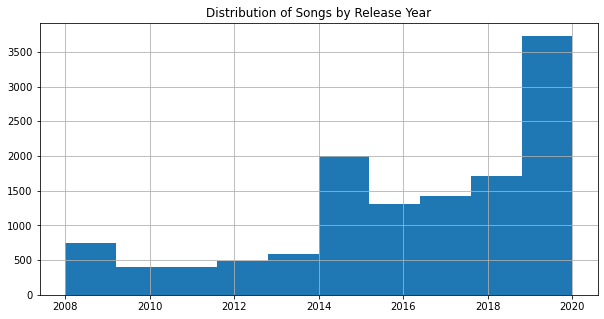

In [33]:
# create a column for release year
kaggle_df['release_year'] = pd.DatetimeIndex(kaggle_df['track_album_release_date']).year

plt.figure(figsize=(10,5))
plt.hist(kaggle_df['release_year'])
plt.title('Distribution of Songs by Release Year')
plt.grid()
plt.show()

From here, I will explain the next steps in markdown code. As mentioned, this was a iterative process which required multiple data verifications, merging, and dropping. We assume at this point, we already have a full dataset with just the Billboard Hot100 songs.

The main issue to address before merging is **duplicate songs**. Think: how much of this data already exists in the Billboard Hot100 dataset? There are several ways to approach this:

#### Match by the Spotify track URI
```python
# store the duplicate track URI's
duplicate_uri = []

# loop through billboard and kaggle's datasets
for x in billboard_df['track_uri']:
    for y in kaggle_df['track_uri']:
        if x == y:
            duplicate_uri.append(y)

# drop the columns with duplicate track URI 
for i in kaggle_df['track_uri']:
    if i in duplicate_uri:
        kaggle_df.drop(kaggle_df[kaggle_df['track_uri'] == i].index, inplace = True)
            
```

#### Match by the song title then match again by artist
```python
# empty dictionary to store results
dupe_songs = {
    'billboard_song':[],
    'kaggle_song':[],
    'billboard_artist':[],
    'kaggle_artist':[]
}

# loop through combination of song & artist in each dataset
# append data if song titles that match
for a, b in zip(billboard_df['song'],billboard_df['artist']):
    for c, d in zip(kaggle_df['song'], kaggle_df['artist']):
        if a == c:
            dupe_songs['billboard_song'].append(a)
            dupe_songs['billboard_artist'].append(b)
            dupe_songs['kaggle_song'].append(c)
            dupe_songs['kaggle_artist'].append(d)

# create a dataframe with dictionary
dupe_df = pd.DataFrame(dupe_songs)         

# filter dataframe where artist names match
dupe_df = dupe_df[dupe_df['billboard_artist'] == dupe_df['kaggle_artist']]

# drop the rows that have duplicate song/artist
for a, b in zip(kaggle2_df['song'], kaggle2_df['artist']):
    for c, d in zip(match_df['kag_song'], match_df['kag_artist']):
        if a == c and b == d:
            kaggle2_df.drop(kaggle2_df[(kaggle2_df['song'] == c) & (kaggle2_df['artist'] == d)].index, inplace = True)

```

#### Use fuzzywuzzy's .get_close_matches method

```python
# install necessary packages
pip install fuzzywuzzy
pip install python-Levenshtein

# create columns for fuzzywuzzy match
billboard_df['fuzzy'] = billboard_df['song'] + ' ' + billboard_df['artist]
kaggle_df['fuzzy'] = kaggle_df['song'] + ' ' + kaggle_df['artist']
                                                                  
# create a column for the output
kaggle_df['fuzzy_match'] = kaggle_df['fuzzy']
                                                                  
# calculate score based on both 'fuzzy' columns
kaggle_df['fuzzy_match'] = kaggle_df['fuzzy_match'].apply(lambda x: difflib.get_close_matches(x, billboard_df['fuzzy']))
```

From here, we would need to review the `kaggle_df['fuzzy']` and `kaggle_df['fuzzy_match']` columns, and manually detect and drop the duplicates. This method works well for songs that may or may not have a featured artist or for when the titles are spelled differently.

#### Use fuzzywuzzy's token set ratio method

```python
fuzzy_billboard = []
fuzzy_kaggle = []
fuzzy_score = []

for x in kaggle_df['fuzzy']:
    for y in billboard_df['fuzzy']:
        score = fuzz.token_set_ratio(x, y)
        if score > 90:
            fuzzy_kaggle.append(x)
            fuzzy_billboard.append(y)
            fuzzy_score.append(score)

df = pd.DataFrame({
    'billboard':fuzzy_billboard,
    'kaggle': fuzzy_kaggle,
    'score': fuzzy_score
})

df = df.sort_values(by='score', ascending=False)
```
This method takes a while to run and also requires user to review columns before dropping.

### Data.World Dataset<a class="anchor" id="dataworld"></a>

data.world is a great website that hosts a variety of datasets. What is also great about this platform is that we can run queries to transform the dataset before downloading it. This is especially beneficial when the file is too large. Based on the image below, I filtered this large dataset to release year 2008 onwards.

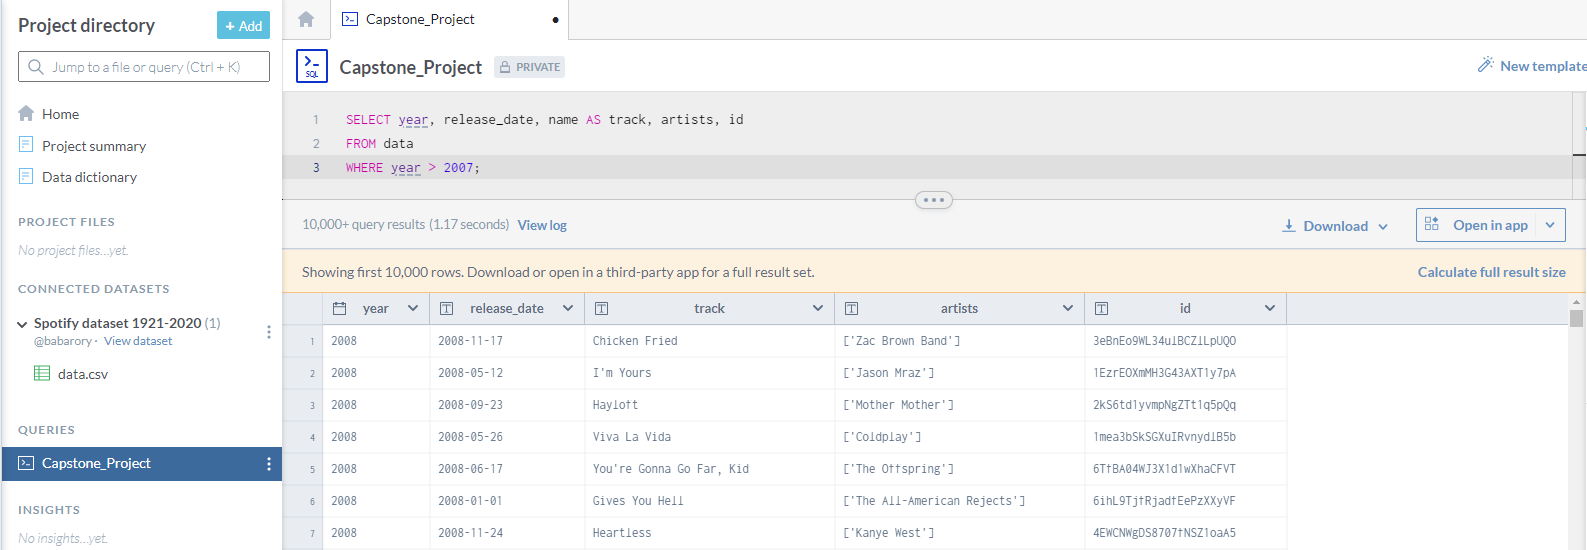

In [7]:
dataworld_df = pd.read_csv('dataset_dataworld.csv')

In [41]:
dataworld_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25719 entries, 0 to 25718
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   year          25719 non-null  int64 
 1   release_date  25719 non-null  object
 2   track         25719 non-null  object
 3   artists       25719 non-null  object
 4   id            25719 non-null  object
dtypes: int64(1), object(4)
memory usage: 1004.8+ KB


In [43]:
dataworld_df.sample(5)

,year,release_date,track,artists,id
10997,2011,2011-01-01,Headlines,['Drake'],6RGvWCHTS6BC46TsMyN0WM
19197,2013,2013-01-01,Cruise - Remix,"['Florida Georgia Line', 'Nelly']",2z8OXShNGUgRitHyO3GuYG
15529,2015,2015-06-28,Virus Techno,['XTerminator'],4LfJpGCpc9q6ej0x3yAO9G
21141,2010,2010-05-14,Lay It on the Line,['Triumph'],4QwcuKjGjtl5fZe7kDdULV
4107,2015,2015-08-28,Dark Times,"['The Weeknd', 'Ed Sheeran']",6J7PIkhtHwmFjPLq0SyuPj


Something we notice right away here is that the artists are in a list-looking string format. Featured artists are separated by a comma within the brackets. We need to separate this column and remove the special characters.

In [44]:
# split the artists column into main artist and featured artists
dataworld_df[['artist','feat_artist']] = dataworld_df.pop('artists').str.split(',\s*', n=1, expand=True)

# remove the special characters from artist
dataworld_df['artist'] = dataworld_df['artist'].str.replace('[^a-zA-Z0-9 ]', '')

# remove the special characters from featured artists
dataworld_df['feat_artist'] = dataworld_df['feat_artist'].str.replace('[^a-zA-Z0-9 ,]', '')

C:\Users\eunji\AppData\Local\Temp\ipykernel_24872\2260562538.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  dataworld_df['artist'] = dataworld_df['artist'].str.replace('[^a-zA-Z0-9 ]', '')
C:\Users\eunji\AppData\Local\Temp\ipykernel_24872\2260562538.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  dataworld_df['feat_artist'] = dataworld_df['feat_artist'].str.replace('[^a-zA-Z0-9 ,]', '')


In [45]:
dataworld_df.sample(5)

,year,release_date,track,id,artist,feat_artist
17568,2018,2018-07-27,I Wanna Know,4ToogKQq58R9TvO40qRuxi,RL Grime,Daya
17002,2015,2015-06-02,Soy Yo,4Egb5xP6cniUx0kgZd5zLB,Bomba Estreo,None
1443,2015,2015-09-25,Wait for It,7EqpEBPOohgk7NnKvBGFWo,Leslie Odom Jr,Original Broadway Cast of Hamilton
1002,2013,2013-08-30,All of Me,3U4isOIWM3VvDubwSI3y7a,John Legend,None
18362,2008,2008,"El Amor de Mi Vida ""Se Fue""",4ee1fUrPVok1bEyj1cm4Rv,Grupo Gal,None


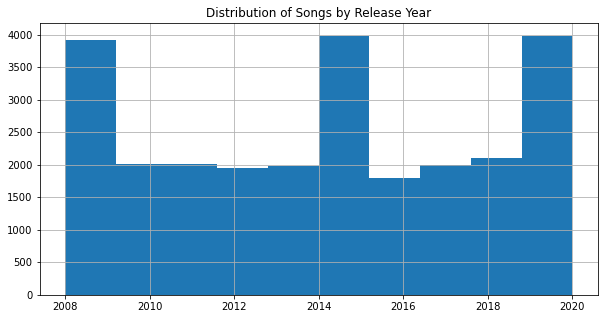

In [47]:
# look at song distribution by year
plt.figure(figsize=(10,5))
plt.hist(dataworld_df['year'])
plt.title('Distribution of Songs by Release Year')
plt.grid()
plt.show()

Below is a screenshot of what I had while analyzing these datasets. The right graph showed the distribution *after* the Kaggle dataset had been merged with Billboard Hot100. There is imbalance here and more data was needed for 2008-2014. To address this, I sampled off the large data.world dataset and repeated the merging process until there were no more duplicates. The sampling was done to reduce the workload of finding duplicates.

Code for sampling:
```python
dataworld_df = dataworld_df[dataworld_df['year'] < 2014].sample(frac=0.5)
```

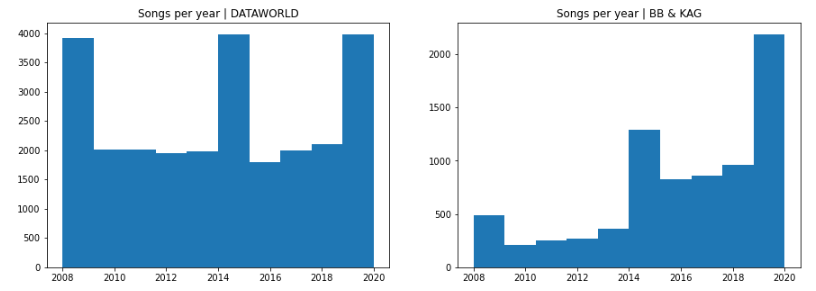

Finally, once the data had been checked for duplicates and there was reasonable balance in each year, I just needed to run the API codes to fill in the blanks for Spotify metrics and Genius lyrics on the additional songs.

---

<center>2022 BrainStation Capstone Project
    <br>"Is the song <i>hot enough</i> for Billboard Hot100?"
    <br>by Hailey Lee</center>